# Statistical Analysis: UIT-ViSD4SA Dataset

## Vietnamese Aspect-Based Sentiment Analysis for E-commerce Reviews

This notebook provides comprehensive statistical analysis of the UIT-ViSD4SA dataset, which contains Vietnamese customer reviews with aspect-level sentiment annotations.

**Dataset Structure:**
- Format: JSONL with `text` and `labels` fields
- Labels: `[start_pos, end_pos, "ASPECT#SENTIMENT"]` tuples
- Aspects: BATTERY, CAMERA, DESIGN, FEATURES, GENERAL, PERFORMANCE, PRICE, SCREEN, SER&ACC, STORAGE
- Sentiments: POSITIVE, NEGATIVE, NEUTRAL


In [3]:
import json
import os
from collections import Counter, defaultdict
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Configure visualization style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12

print("Libraries loaded successfully.")


Libraries loaded successfully.


## 1. Data Loading and Preprocessing

Load all JSONL files from train, dev, and test splits, then merge them into a unified dataset with split identifiers.


In [4]:
def load_jsonl(filepath: str) -> list[dict]:
    """Load a JSONL file and return a list of dictionaries."""
    data = []
    with open(filepath, 'r', encoding='utf-8') as f:
        for line in f:
            if line.strip():
                data.append(json.loads(line))
    return data


def parse_labels(labels: list) -> list[dict]:
    """Parse label tuples into structured dictionaries."""
    parsed = []
    for label in labels:
        start, end, aspect_sentiment = label
        aspect, sentiment = aspect_sentiment.split('#')
        parsed.append({
            'start': start,
            'end': end,
            'aspect': aspect,
            'sentiment': sentiment,
            'span_length': end - start
        })
    return parsed


# Define data paths
DATA_DIR = Path('../UIT-ViSD4SA/data')
SPLITS = ['train', 'dev', 'test']

# Load all splits
datasets = {}
for split in SPLITS:
    filepath = DATA_DIR / f'{split}.jsonl'
    datasets[split] = load_jsonl(filepath)
    print(f"Loaded {split}: {len(datasets[split]):,} samples")

# Merge all data with split identifier
all_data = []
for split, data in datasets.items():
    for item in data:
        item['split'] = split
        item['parsed_labels'] = parse_labels(item['labels'])
        item['num_labels'] = len(item['labels'])
        item['char_count'] = len(item['text'])
        item['word_count'] = len(item['text'].split())
        all_data.append(item)

print(f"\nTotal samples: {len(all_data):,}")


Loaded train: 7,785 samples
Loaded dev: 1,112 samples
Loaded test: 2,225 samples

Total samples: 11,122


## 2. Basic Statistics

Overview of dataset size, annotation counts, and distribution across splits.


In [5]:
# Convert to DataFrame for easier analysis
df = pd.DataFrame(all_data)

# Basic statistics per split
split_stats = df.groupby('split').agg({
    'text': 'count',
    'num_labels': ['sum', 'mean', 'std', 'min', 'max'],
    'word_count': ['mean', 'std', 'min', 'max'],
    'char_count': ['mean', 'std', 'min', 'max']
}).round(2)

split_stats.columns = ['_'.join(col).strip() for col in split_stats.columns.values]
split_stats = split_stats.rename(columns={'text_count': 'sample_count'})

# Reorder columns for better readability
print("=" * 80)
print("DATASET SPLIT STATISTICS")
print("=" * 80)

for split in ['train', 'dev', 'test']:
    row = split_stats.loc[split]
    print(f"\n{split.upper()} Split:")
    print(f"  - Samples: {int(row['sample_count']):,}")
    print(f"  - Total annotations: {int(row['num_labels_sum']):,}")
    print(f"  - Avg annotations/sample: {row['num_labels_mean']:.2f} (std: {row['num_labels_std']:.2f})")
    print(f"  - Avg word count: {row['word_count_mean']:.1f} (std: {row['word_count_std']:.1f})")
    print(f"  - Avg char count: {row['char_count_mean']:.1f} (std: {row['char_count_std']:.1f})")

# Overall statistics
print("\n" + "=" * 80)
print("OVERALL STATISTICS")
print("=" * 80)
total_samples = len(df)
total_annotations = df['num_labels'].sum()
avg_annotations = df['num_labels'].mean()

print(f"Total samples: {total_samples:,}")
print(f"Total aspect-sentiment annotations: {total_annotations:,}")
print(f"Average annotations per sample: {avg_annotations:.2f}")
print(f"Average word count: {df['word_count'].mean():.1f}")
print(f"Average character count: {df['char_count'].mean():.1f}")


DATASET SPLIT STATISTICS

TRAIN Split:
  - Samples: 7,785
  - Total annotations: 24,771
  - Avg annotations/sample: 3.18 (std: 1.73)
  - Avg word count: 36.0 (std: 19.8)
  - Avg char count: 158.1 (std: 86.3)

DEV Split:
  - Samples: 1,112
  - Total annotations: 3,582
  - Avg annotations/sample: 3.22 (std: 1.84)
  - Avg word count: 35.8 (std: 21.4)
  - Avg char count: 156.9 (std: 92.8)

TEST Split:
  - Samples: 2,225
  - Total annotations: 7,043
  - Avg annotations/sample: 3.17 (std: 1.74)
  - Avg word count: 36.3 (std: 20.6)
  - Avg char count: 159.8 (std: 90.2)

OVERALL STATISTICS
Total samples: 11,122
Total aspect-sentiment annotations: 35,396
Average annotations per sample: 3.18
Average word count: 36.0
Average character count: 158.3


In [6]:
# Create summary table
summary_data = {
    'Split': ['Train', 'Dev', 'Test', 'Total'],
    'Samples': [
        len(datasets['train']),
        len(datasets['dev']),
        len(datasets['test']),
        len(all_data)
    ],
    'Annotations': [
        df[df['split'] == 'train']['num_labels'].sum(),
        df[df['split'] == 'dev']['num_labels'].sum(),
        df[df['split'] == 'test']['num_labels'].sum(),
        df['num_labels'].sum()
    ],
    'Percentage': [
        f"{len(datasets['train']) / len(all_data) * 100:.1f}%",
        f"{len(datasets['dev']) / len(all_data) * 100:.1f}%",
        f"{len(datasets['test']) / len(all_data) * 100:.1f}%",
        "100%"
    ]
}

summary_df = pd.DataFrame(summary_data)
summary_df['Avg Ann/Sample'] = (summary_df['Annotations'] / summary_df['Samples']).round(2)

print("\nDataset Summary Table:")
print(summary_df.to_string(index=False))



Dataset Summary Table:
Split  Samples  Annotations Percentage  Avg Ann/Sample
Train     7785        24771      70.0%            3.18
  Dev     1112         3582      10.0%            3.22
 Test     2225         7043      20.0%            3.17
Total    11122        35396       100%            3.18


## 3. Aspect Category Analysis

Analyze the distribution of aspect categories across the entire dataset. The dataset contains 10 aspect categories:
- **BATTERY**: Battery life and charging
- **CAMERA**: Camera quality and features
- **DESIGN**: Physical design and aesthetics
- **FEATURES**: General features and functionality
- **GENERAL**: Overall product evaluation
- **PERFORMANCE**: Speed, smoothness, processing power
- **PRICE**: Price and value assessment
- **SCREEN**: Display quality
- **SER&ACC**: Service and accessories
- **STORAGE**: Storage capacity


In [7]:
# Extract all aspect-sentiment labels into a flat list
all_labels = []
for item in all_data:
    for label in item['parsed_labels']:
        label['split'] = item['split']
        all_labels.append(label)

labels_df = pd.DataFrame(all_labels)
print(f"Total aspect-sentiment annotations: {len(labels_df):,}")

# Aspect distribution
aspect_counts = labels_df['aspect'].value_counts()
aspect_pct = (aspect_counts / len(labels_df) * 100).round(2)

print("\n" + "=" * 60)
print("ASPECT CATEGORY DISTRIBUTION")
print("=" * 60)
aspect_summary = pd.DataFrame({
    'Aspect': aspect_counts.index,
    'Count': aspect_counts.values,
    'Percentage': [f"{p:.2f}%" for p in aspect_pct.values]
})
print(aspect_summary.to_string(index=False))


Total aspect-sentiment annotations: 35,396

ASPECT CATEGORY DISTRIBUTION
     Aspect  Count Percentage
    GENERAL   8057     22.76%
PERFORMANCE   6906     19.51%
    BATTERY   5630     15.91%
   FEATURES   3994     11.28%
     CAMERA   3117      8.81%
    SER&ACC   2635      7.44%
     DESIGN   2141      6.05%
      PRICE   1389      3.92%
     SCREEN   1382      3.90%
    STORAGE    145      0.41%


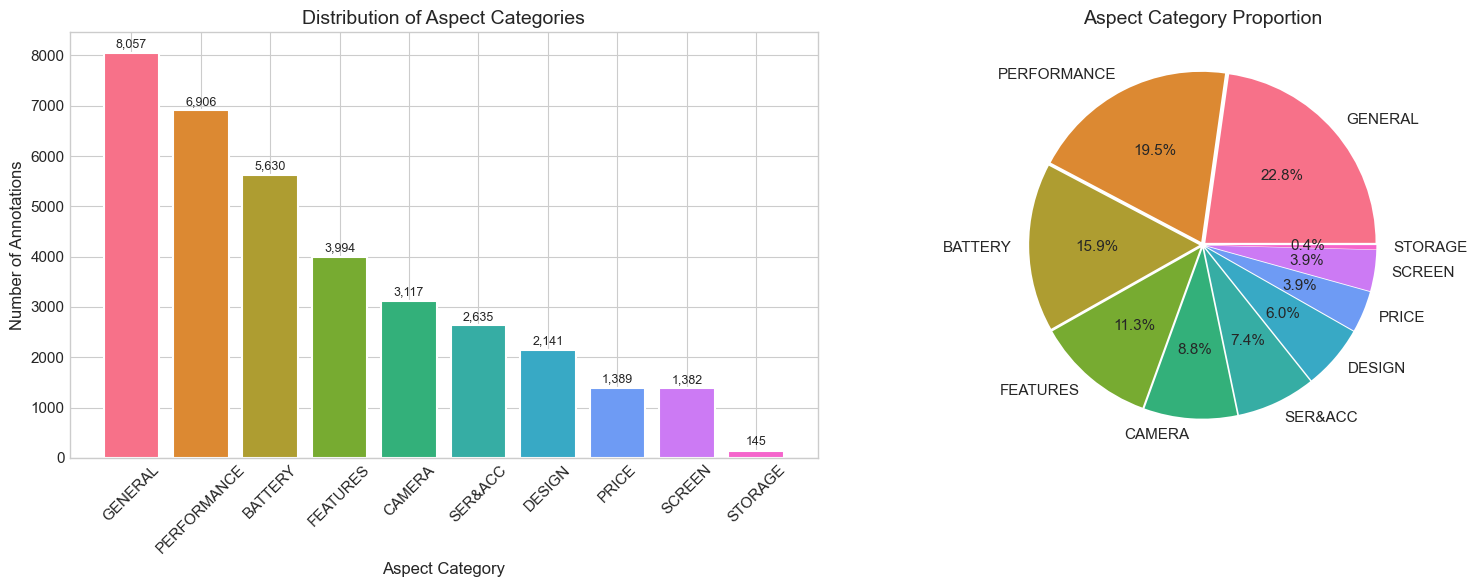


------------------------------------------------------------
OBSERVATION:
------------------------------------------------------------
- The most frequent aspect is 'GENERAL' with 8,057 annotations (22.8%)
- The least frequent aspect is 'STORAGE' with 145 annotations (0.4%)
- Top 3 aspects account for 58.2% of all annotations


In [ ]:
# Visualize aspect distribution
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Bar chart
colors = sns.color_palette("husl", len(aspect_counts))
bars = axes[0].bar(aspect_counts.index, aspect_counts.values, color=colors, edgecolor='white', linewidth=1.5)
axes[0].set_xlabel('Aspect Category')
axes[0].set_ylabel('Number of Annotations')
axes[0].set_title('Distribution of Aspect Categories')
axes[0].tick_params(axis='x', rotation=45)

# Add value labels on bars
for bar, count in zip(bars, aspect_counts.values):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 50, 
                 f'{count:,}', ha='center', va='bottom', fontsize=9)

# Pie chart
wedges, texts, autotexts = axes[1].pie(aspect_counts.values, labels=aspect_counts.index, 
                                        autopct='%1.1f%%', colors=colors,
                                        explode=[0.02]*len(aspect_counts))
axes[1].set_title('Aspect Category Proportion')

plt.tight_layout()
plt.savefig('statistical_result/aspect_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

# Observation
print("\n" + "-" * 60)
print("OBSERVATION:")
print("-" * 60)
print(f"- The most frequent aspect is '{aspect_counts.index[0]}' with {aspect_counts.values[0]:,} annotations ({aspect_pct.values[0]:.1f}%)")
print(f"- The least frequent aspect is '{aspect_counts.index[-1]}' with {aspect_counts.values[-1]:,} annotations ({aspect_pct.values[-1]:.1f}%)")
print(f"- Top 3 aspects account for {aspect_pct.values[:3].sum():.1f}% of all annotations")


## 4. Sentiment Distribution

Analyze the distribution of sentiment labels (POSITIVE, NEGATIVE, NEUTRAL) both overall and per aspect category.


OVERALL SENTIMENT DISTRIBUTION
Sentiment  Count Percentage
 POSITIVE  21832     61.68%
 NEGATIVE  11350     32.07%
  NEUTRAL   2214      6.25%


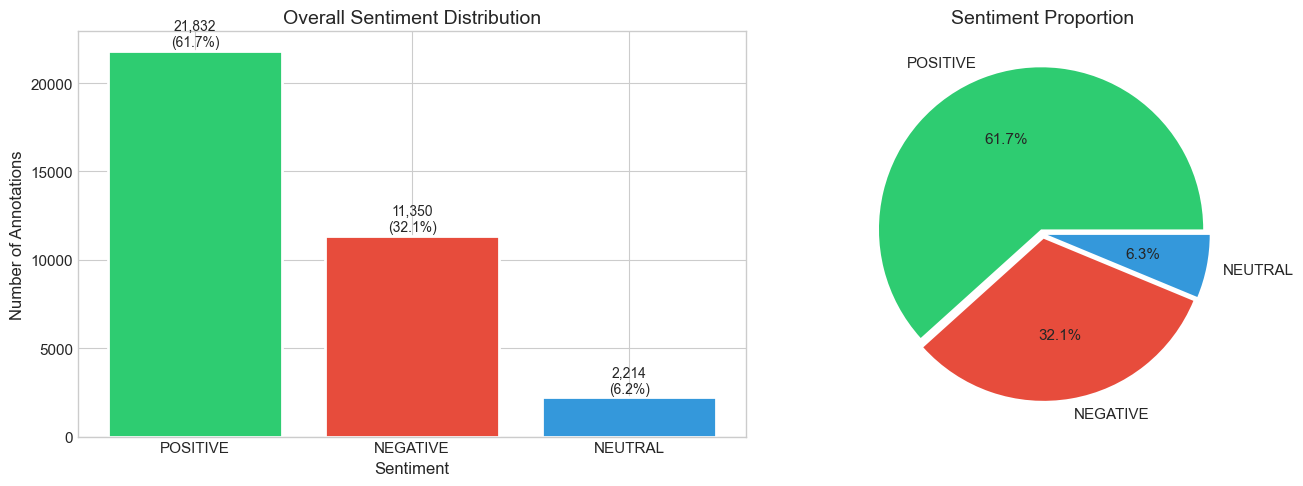


------------------------------------------------------------
OBSERVATION:
------------------------------------------------------------
- POSITIVE sentiment dominates with 61.7% of annotations
- The dataset shows a class imbalance typical of e-commerce review datasets
- POSITIVE:NEGATIVE:NEUTRAL ratio is approximately 218:113:22


In [ ]:
# Overall sentiment distribution
sentiment_counts = labels_df['sentiment'].value_counts()
sentiment_pct = (sentiment_counts / len(labels_df) * 100).round(2)

print("=" * 60)
print("OVERALL SENTIMENT DISTRIBUTION")
print("=" * 60)
sentiment_summary = pd.DataFrame({
    'Sentiment': sentiment_counts.index,
    'Count': sentiment_counts.values,
    'Percentage': [f"{p:.2f}%" for p in sentiment_pct.values]
})
print(sentiment_summary.to_string(index=False))

# Visualize sentiment distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Color mapping for sentiments
sentiment_colors = {'POSITIVE': '#2ecc71', 'NEGATIVE': '#e74c3c', 'NEUTRAL': '#3498db'}
colors = [sentiment_colors[s] for s in sentiment_counts.index]

# Bar chart
bars = axes[0].bar(sentiment_counts.index, sentiment_counts.values, color=colors, edgecolor='white', linewidth=2)
axes[0].set_xlabel('Sentiment')
axes[0].set_ylabel('Number of Annotations')
axes[0].set_title('Overall Sentiment Distribution')

for bar, count, pct in zip(bars, sentiment_counts.values, sentiment_pct.values):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 100, 
                 f'{count:,}\n({pct:.1f}%)', ha='center', va='bottom', fontsize=10)

# Pie chart
wedges, texts, autotexts = axes[1].pie(sentiment_counts.values, labels=sentiment_counts.index, 
                                        autopct='%1.1f%%', colors=colors,
                                        explode=[0.03]*len(sentiment_counts),
                                        textprops={'fontsize': 11})
axes[1].set_title('Sentiment Proportion')

plt.tight_layout()
plt.savefig('statistical_result/sentiment_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

# Observation
print("\n" + "-" * 60)
print("OBSERVATION:")
print("-" * 60)
print(f"- POSITIVE sentiment dominates with {sentiment_pct.get('POSITIVE', 0):.1f}% of annotations")
print(f"- The dataset shows a class imbalance typical of e-commerce review datasets")
print(f"- POSITIVE:NEGATIVE:NEUTRAL ratio is approximately {sentiment_counts.get('POSITIVE', 0)//100}:{sentiment_counts.get('NEGATIVE', 0)//100}:{sentiment_counts.get('NEUTRAL', 0)//100}")


ASPECT-SENTIMENT CROSS-TABULATION
sentiment    POSITIVE  NEGATIVE  NEUTRAL
aspect                                  
BATTERY          3290      1935      405
CAMERA           1801       930      386
DESIGN           1560       515       66
FEATURES         1312      2537      145
GENERAL          6338      1357      362
PERFORMANCE      3926      2596      384
PRICE             743       310      336
SCREEN            751       573       58
SER&ACC          2027       565       43
STORAGE            84        32       29


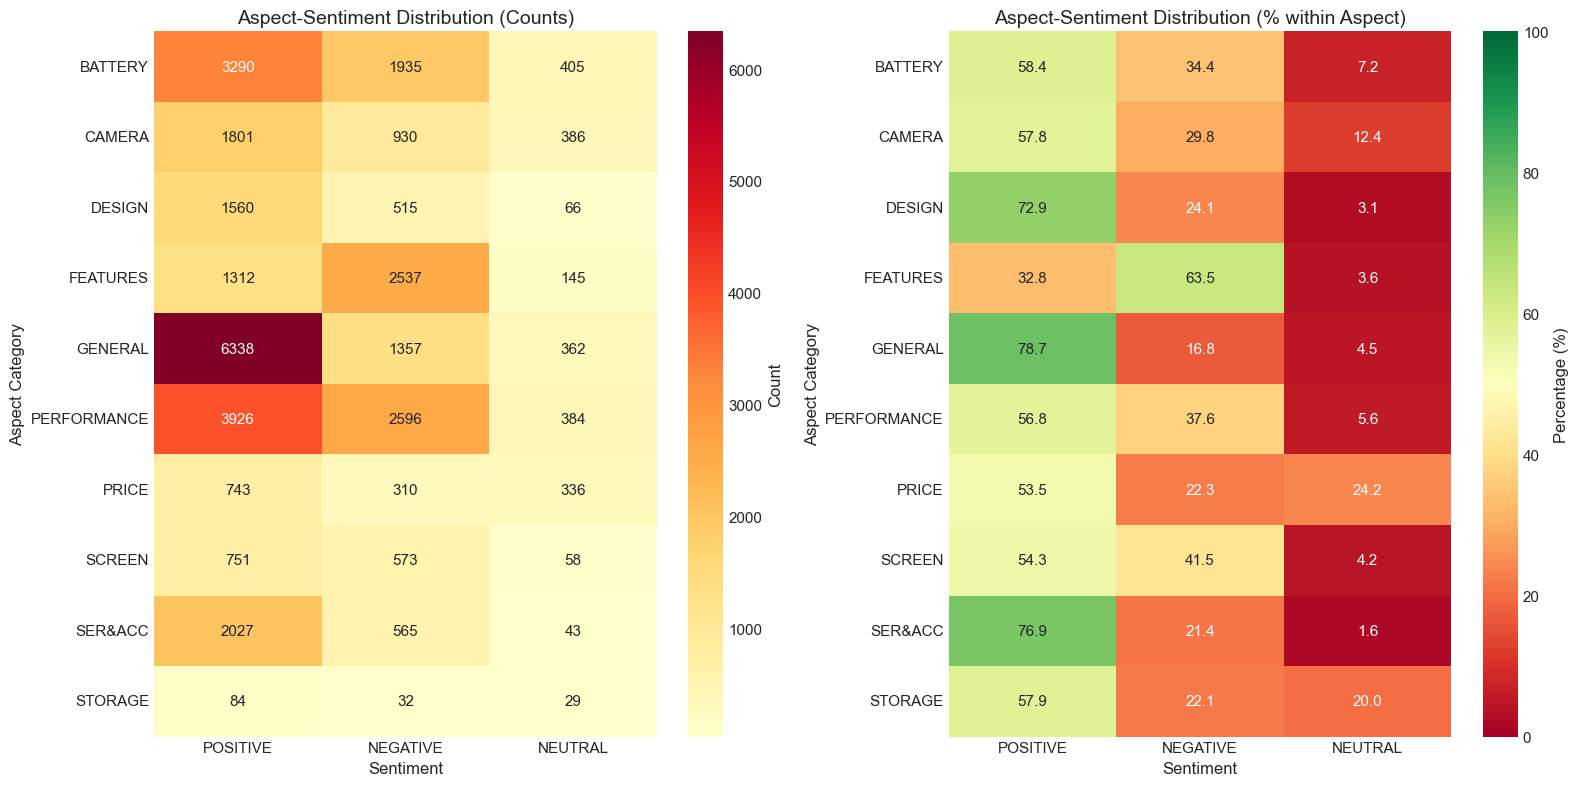


------------------------------------------------------------
OBSERVATION:
------------------------------------------------------------
- 'GENERAL' has the highest positive sentiment ratio (78.7%)
- 'FEATURES' has the highest negative sentiment ratio (63.5%)
- Most aspects show positive-dominant patterns, consistent with e-commerce review characteristics


In [ ]:
# Aspect-Sentiment cross-tabulation
aspect_sentiment_crosstab = pd.crosstab(labels_df['aspect'], labels_df['sentiment'])

# Reorder columns for consistency
sentiment_order = ['POSITIVE', 'NEGATIVE', 'NEUTRAL']
aspect_sentiment_crosstab = aspect_sentiment_crosstab[[s for s in sentiment_order if s in aspect_sentiment_crosstab.columns]]

print("=" * 60)
print("ASPECT-SENTIMENT CROSS-TABULATION")
print("=" * 60)
print(aspect_sentiment_crosstab)

# Heatmap visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Raw counts heatmap
sns.heatmap(aspect_sentiment_crosstab, annot=True, fmt='d', cmap='YlOrRd', 
            ax=axes[0], cbar_kws={'label': 'Count'})
axes[0].set_title('Aspect-Sentiment Distribution (Counts)')
axes[0].set_xlabel('Sentiment')
axes[0].set_ylabel('Aspect Category')

# Normalized heatmap (row-wise percentage)
aspect_sentiment_pct = aspect_sentiment_crosstab.div(aspect_sentiment_crosstab.sum(axis=1), axis=0) * 100
sns.heatmap(aspect_sentiment_pct, annot=True, fmt='.1f', cmap='RdYlGn', 
            ax=axes[1], cbar_kws={'label': 'Percentage (%)'}, vmin=0, vmax=100)
axes[1].set_title('Aspect-Sentiment Distribution (% within Aspect)')
axes[1].set_xlabel('Sentiment')
axes[1].set_ylabel('Aspect Category')

plt.tight_layout()
plt.savefig('statistical_result/aspect_sentiment_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()

# Observation
print("\n" + "-" * 60)
print("OBSERVATION:")
print("-" * 60)
most_positive_aspect = aspect_sentiment_pct['POSITIVE'].idxmax()
most_negative_aspect = aspect_sentiment_pct['NEGATIVE'].idxmax()
print(f"- '{most_positive_aspect}' has the highest positive sentiment ratio ({aspect_sentiment_pct.loc[most_positive_aspect, 'POSITIVE']:.1f}%)")
print(f"- '{most_negative_aspect}' has the highest negative sentiment ratio ({aspect_sentiment_pct.loc[most_negative_aspect, 'NEGATIVE']:.1f}%)")
print(f"- Most aspects show positive-dominant patterns, consistent with e-commerce review characteristics")


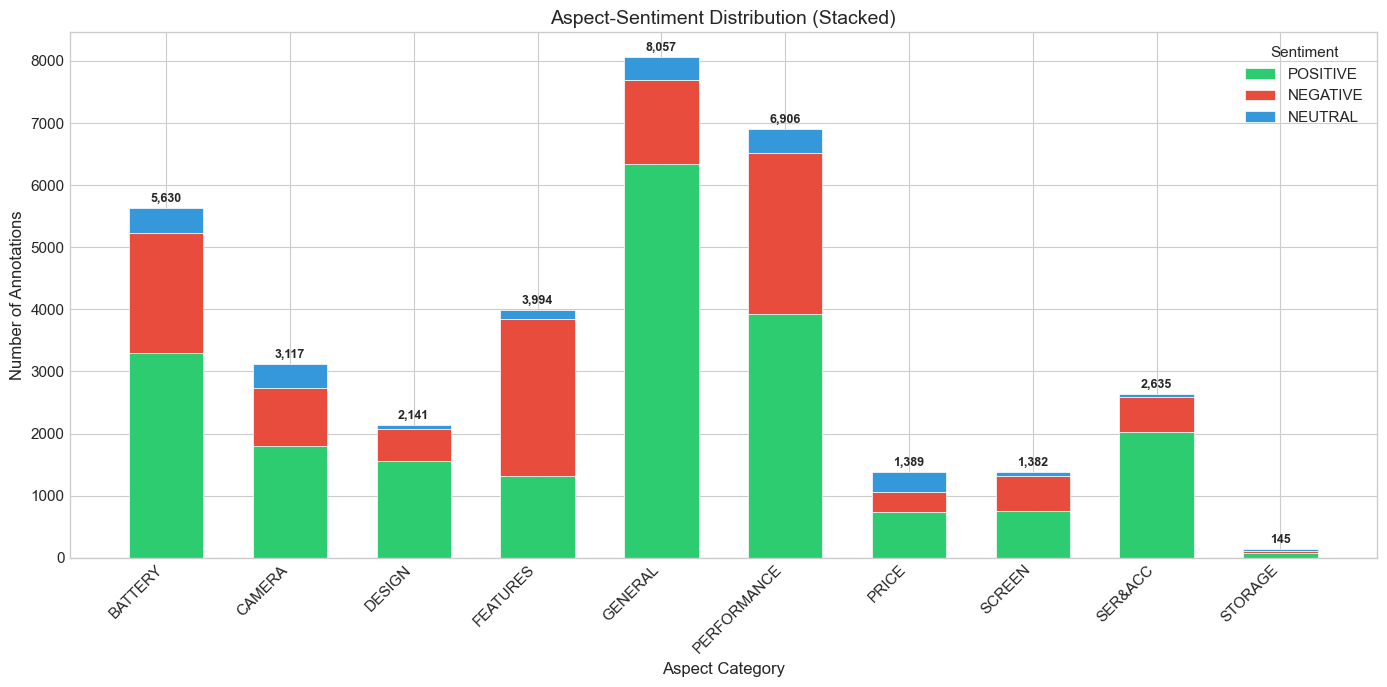

In [ ]:
# Stacked bar chart for aspect-sentiment distribution
fig, ax = plt.subplots(figsize=(14, 7))

# Prepare data for stacked bar
aspects = aspect_sentiment_crosstab.index.tolist()
x = np.arange(len(aspects))
width = 0.6

# Create stacked bars
bottom = np.zeros(len(aspects))
sentiment_colors_map = {'POSITIVE': '#2ecc71', 'NEGATIVE': '#e74c3c', 'NEUTRAL': '#3498db'}

for sentiment in sentiment_order:
    if sentiment in aspect_sentiment_crosstab.columns:
        values = aspect_sentiment_crosstab[sentiment].values
        ax.bar(x, values, width, label=sentiment, bottom=bottom, 
               color=sentiment_colors_map[sentiment], edgecolor='white', linewidth=0.5)
        bottom += values

ax.set_xlabel('Aspect Category')
ax.set_ylabel('Number of Annotations')
ax.set_title('Aspect-Sentiment Distribution (Stacked)')
ax.set_xticks(x)
ax.set_xticklabels(aspects, rotation=45, ha='right')
ax.legend(title='Sentiment', loc='upper right')

# Add total count labels on top
totals = aspect_sentiment_crosstab.sum(axis=1).values
for i, (aspect, total) in enumerate(zip(aspects, totals)):
    ax.text(i, total + 50, f'{total:,}', ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.savefig('statistical_result/aspect_sentiment_stacked.png', dpi=150, bbox_inches='tight')
plt.show()


## 5. Text Length Analysis

Analyze the distribution of text lengths (word count and character count) across the dataset.


In [12]:
# Text length statistics
print("=" * 60)
print("TEXT LENGTH STATISTICS")
print("=" * 60)

text_stats = df[['word_count', 'char_count']].describe().round(2)
print(text_stats)

# Percentiles
print("\n" + "-" * 40)
print("PERCENTILES:")
print("-" * 40)
percentiles = [10, 25, 50, 75, 90, 95, 99]
for col in ['word_count', 'char_count']:
    print(f"\n{col.replace('_', ' ').title()}:")
    for p in percentiles:
        val = df[col].quantile(p/100)
        print(f"  {p}th percentile: {val:.0f}")


TEXT LENGTH STATISTICS
       word_count  char_count
count    11122.00    11122.00
mean        36.02      158.28
std         20.08       87.80
min          2.00       10.00
25%         22.00       98.00
50%         29.00      128.00
75%         43.00      188.00
max        205.00      850.00

----------------------------------------
PERCENTILES:
----------------------------------------

Word Count:
  10th percentile: 19
  25th percentile: 22
  50th percentile: 29
  75th percentile: 43
  90th percentile: 63
  95th percentile: 78
  99th percentile: 107

Char Count:
  10th percentile: 85
  25th percentile: 98
  50th percentile: 128
  75th percentile: 188
  90th percentile: 278
  95th percentile: 340
  99th percentile: 474


/var/folders/zq/fx7nz5vs08311g22z6wlklym0000gn/T/ipykernel_9957/289585872.py:25: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp1 = axes[1, 0].boxplot([df[df['split'] == s]['word_count'].values for s in split_order],
/var/folders/zq/fx7nz5vs08311g22z6wlklym0000gn/T/ipykernel_9957/289585872.py:35: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp2 = axes[1, 1].boxplot([df[df['split'] == s]['char_count'].values for s in split_order],


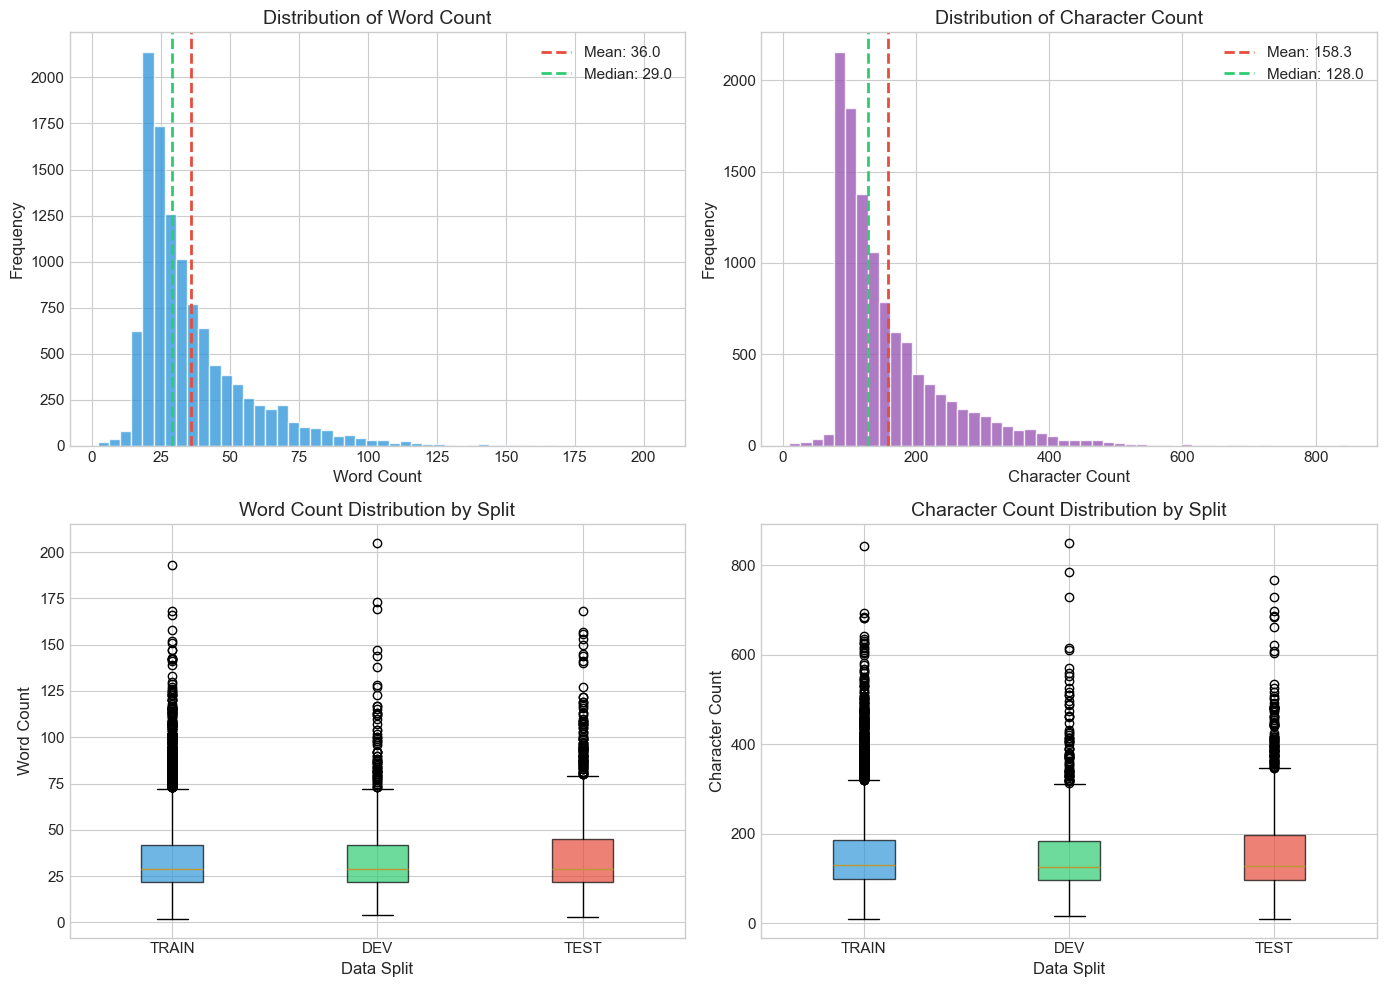


------------------------------------------------------------
OBSERVATION:
------------------------------------------------------------
- Average review length: 36.0 words (158.3 characters)
- Reviews are relatively short, typical for e-commerce product reviews
- Distribution is right-skewed with some longer reviews as outliers
- Text length is consistent across train/dev/test splits, indicating proper stratification


In [13]:
# Text length distribution visualizations
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Word count histogram
axes[0, 0].hist(df['word_count'], bins=50, color='#3498db', edgecolor='white', alpha=0.8)
axes[0, 0].axvline(df['word_count'].mean(), color='#e74c3c', linestyle='--', linewidth=2, label=f'Mean: {df["word_count"].mean():.1f}')
axes[0, 0].axvline(df['word_count'].median(), color='#2ecc71', linestyle='--', linewidth=2, label=f'Median: {df["word_count"].median():.1f}')
axes[0, 0].set_xlabel('Word Count')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Distribution of Word Count')
axes[0, 0].legend()

# Character count histogram
axes[0, 1].hist(df['char_count'], bins=50, color='#9b59b6', edgecolor='white', alpha=0.8)
axes[0, 1].axvline(df['char_count'].mean(), color='#e74c3c', linestyle='--', linewidth=2, label=f'Mean: {df["char_count"].mean():.1f}')
axes[0, 1].axvline(df['char_count'].median(), color='#2ecc71', linestyle='--', linewidth=2, label=f'Median: {df["char_count"].median():.1f}')
axes[0, 1].set_xlabel('Character Count')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Distribution of Character Count')
axes[0, 1].legend()

# Word count box plot by split
split_order = ['train', 'dev', 'test']
split_colors = {'train': '#3498db', 'dev': '#2ecc71', 'test': '#e74c3c'}
bp1 = axes[1, 0].boxplot([df[df['split'] == s]['word_count'].values for s in split_order], 
                          labels=[s.upper() for s in split_order], patch_artist=True)
for patch, split in zip(bp1['boxes'], split_order):
    patch.set_facecolor(split_colors[split])
    patch.set_alpha(0.7)
axes[1, 0].set_xlabel('Data Split')
axes[1, 0].set_ylabel('Word Count')
axes[1, 0].set_title('Word Count Distribution by Split')

# Character count box plot by split
bp2 = axes[1, 1].boxplot([df[df['split'] == s]['char_count'].values for s in split_order], 
                          labels=[s.upper() for s in split_order], patch_artist=True)
for patch, split in zip(bp2['boxes'], split_order):
    patch.set_facecolor(split_colors[split])
    patch.set_alpha(0.7)
axes[1, 1].set_xlabel('Data Split')
axes[1, 1].set_ylabel('Character Count')
axes[1, 1].set_title('Character Count Distribution by Split')

plt.tight_layout()
plt.savefig('text_length_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

# Observation
print("\n" + "-" * 60)
print("OBSERVATION:")
print("-" * 60)
print(f"- Average review length: {df['word_count'].mean():.1f} words ({df['char_count'].mean():.1f} characters)")
print(f"- Reviews are relatively short, typical for e-commerce product reviews")
print(f"- Distribution is right-skewed with some longer reviews as outliers")
print(f"- Text length is consistent across train/dev/test splits, indicating proper stratification")


## 6. Annotation Statistics

Analyze annotation patterns including multi-label samples, empty annotations, and annotation span lengths.


In [14]:
# Annotation count distribution
print("=" * 60)
print("ANNOTATION COUNT STATISTICS")
print("=" * 60)

annotation_count_dist = df['num_labels'].value_counts().sort_index()
print("\nAnnotation count per review:")
for count, freq in annotation_count_dist.items():
    pct = freq / len(df) * 100
    print(f"  {count} annotation(s): {freq:,} reviews ({pct:.2f}%)")

# Empty annotations (no labels)
empty_count = (df['num_labels'] == 0).sum()
empty_pct = empty_count / len(df) * 100
print(f"\nReviews with NO annotations: {empty_count:,} ({empty_pct:.2f}%)")

# Multi-label statistics
multi_label_count = (df['num_labels'] > 1).sum()
multi_label_pct = multi_label_count / len(df) * 100
print(f"Reviews with MULTIPLE annotations: {multi_label_count:,} ({multi_label_pct:.2f}%)")


ANNOTATION COUNT STATISTICS

Annotation count per review:
  0 annotation(s): 225 reviews (2.02%)
  1 annotation(s): 1,729 reviews (15.55%)
  2 annotation(s): 2,389 reviews (21.48%)
  3 annotation(s): 2,362 reviews (21.24%)
  4 annotation(s): 2,075 reviews (18.66%)
  5 annotation(s): 1,274 reviews (11.45%)
  6 annotation(s): 641 reviews (5.76%)
  7 annotation(s): 241 reviews (2.17%)
  8 annotation(s): 114 reviews (1.02%)
  9 annotation(s): 40 reviews (0.36%)
  10 annotation(s): 24 reviews (0.22%)
  11 annotation(s): 8 reviews (0.07%)

Reviews with NO annotations: 225 (2.02%)
Reviews with MULTIPLE annotations: 9,168 (82.43%)


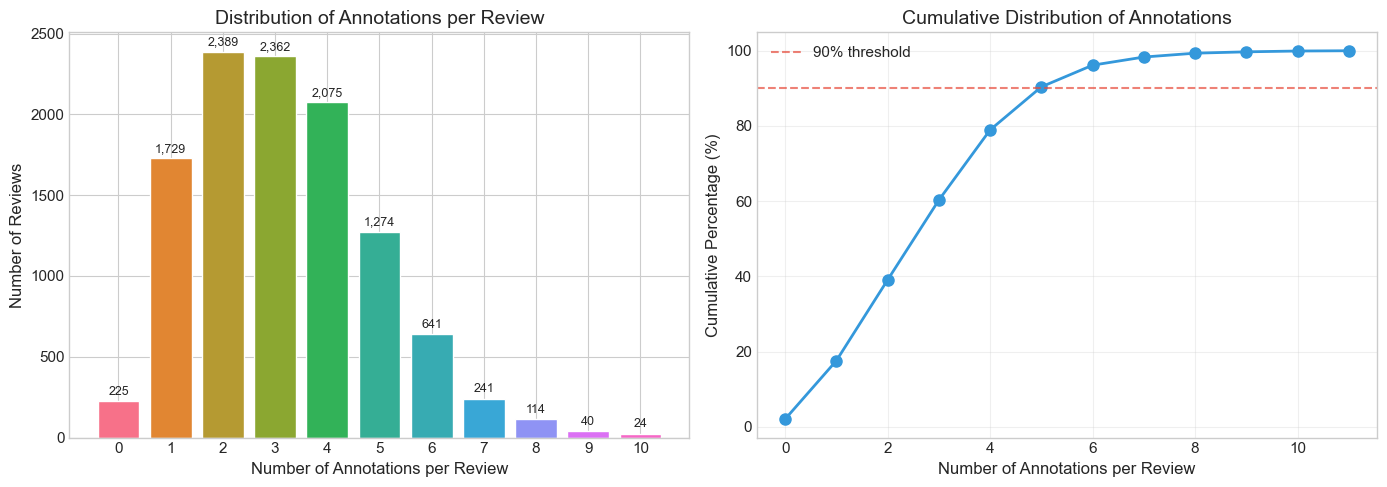


90% of reviews have 5 or fewer annotations

90% of reviews have 6 or fewer annotations

90% of reviews have 7 or fewer annotations

90% of reviews have 8 or fewer annotations

90% of reviews have 9 or fewer annotations

90% of reviews have 10 or fewer annotations

90% of reviews have 11 or fewer annotations


In [ ]:
# Visualization of annotation count distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar chart for annotation count distribution
max_display = min(10, annotation_count_dist.index.max() + 1)
display_counts = annotation_count_dist[annotation_count_dist.index <= max_display]

bars = axes[0].bar(display_counts.index.astype(str), display_counts.values, 
                   color=sns.color_palette("husl", len(display_counts)), edgecolor='white')
axes[0].set_xlabel('Number of Annotations per Review')
axes[0].set_ylabel('Number of Reviews')
axes[0].set_title('Distribution of Annotations per Review')

for bar, val in zip(bars, display_counts.values):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 20, 
                 f'{val:,}', ha='center', va='bottom', fontsize=9)

# Cumulative distribution
cum_counts = annotation_count_dist.sort_index().cumsum()
cum_pct = cum_counts / len(df) * 100
axes[1].plot(cum_counts.index, cum_pct.values, 'o-', color='#3498db', linewidth=2, markersize=8)
axes[1].axhline(y=90, color='#e74c3c', linestyle='--', alpha=0.7, label='90% threshold')
axes[1].set_xlabel('Number of Annotations per Review')
axes[1].set_ylabel('Cumulative Percentage (%)')
axes[1].set_title('Cumulative Distribution of Annotations')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('statistical_result/annotation_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

# Find 90th percentile
for i, pct in enumerate(cum_pct.values):
    if pct >= 90:
        print(f"\n90% of reviews have {cum_counts.index[i]} or fewer annotations")


ANNOTATION SPAN LENGTH STATISTICS
count    35396.00
mean        31.53
std         28.18
min          2.00
25%         14.00
50%         22.00
75%         39.00
max        406.00
Name: span_length, dtype: float64

----------------------------------------
Average span length by aspect:
----------------------------------------
              mean    std  min  max
aspect                             
SER&ACC      47.09  34.05    2  332
FEATURES     39.41  32.48    3  288
PERFORMANCE  37.81  32.12    2  406
BATTERY      32.32  31.66    3  319
SCREEN       29.45  23.00    3  226
CAMERA       29.00  24.60    3  271
STORAGE      28.88  27.45    2  163
DESIGN       26.81  23.39    2  260
GENERAL      21.35  14.04    2  174
PRICE        19.35  15.11    2  172


/var/folders/zq/fx7nz5vs08311g22z6wlklym0000gn/T/ipykernel_9957/2222943267.py:34: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = axes[1].boxplot(box_data, labels=aspect_order, patch_artist=True)


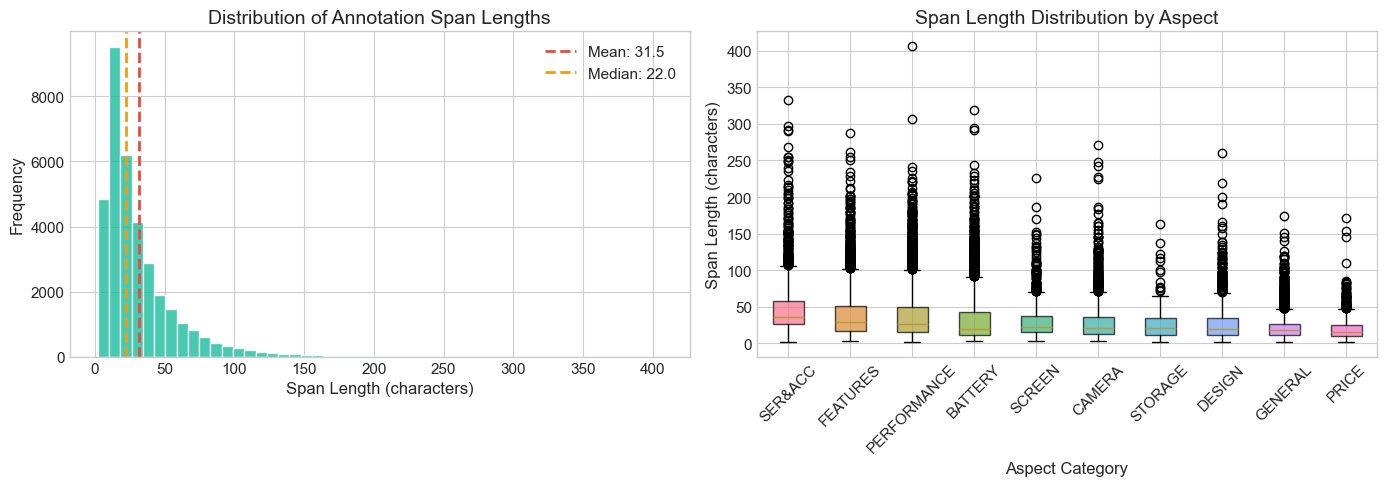


------------------------------------------------------------
OBSERVATION:
------------------------------------------------------------
- Average annotation span: 31.5 characters
- 'SER&ACC' has the longest average span (47.1 chars)
- 'PRICE' has the shortest average span (19.4 chars)
- Span length variation suggests different verbosity across aspect categories


In [ ]:
# Annotation span length analysis
print("=" * 60)
print("ANNOTATION SPAN LENGTH STATISTICS")
print("=" * 60)

span_stats = labels_df['span_length'].describe().round(2)
print(span_stats)

# Span length by aspect
print("\n" + "-" * 40)
print("Average span length by aspect:")
print("-" * 40)
span_by_aspect = labels_df.groupby('aspect')['span_length'].agg(['mean', 'std', 'min', 'max']).round(2)
span_by_aspect = span_by_aspect.sort_values('mean', ascending=False)
print(span_by_aspect)

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram of span lengths
axes[0].hist(labels_df['span_length'], bins=50, color='#1abc9c', edgecolor='white', alpha=0.8)
axes[0].axvline(labels_df['span_length'].mean(), color='#e74c3c', linestyle='--', linewidth=2, 
                label=f'Mean: {labels_df["span_length"].mean():.1f}')
axes[0].axvline(labels_df['span_length'].median(), color='#f39c12', linestyle='--', linewidth=2, 
                label=f'Median: {labels_df["span_length"].median():.1f}')
axes[0].set_xlabel('Span Length (characters)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Annotation Span Lengths')
axes[0].legend()

# Box plot by aspect
aspect_order = span_by_aspect.index.tolist()
box_data = [labels_df[labels_df['aspect'] == a]['span_length'].values for a in aspect_order]
bp = axes[1].boxplot(box_data, labels=aspect_order, patch_artist=True)
colors = sns.color_palette("husl", len(aspect_order))
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)
axes[1].set_xlabel('Aspect Category')
axes[1].set_ylabel('Span Length (characters)')
axes[1].set_title('Span Length Distribution by Aspect')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('statistical_result/span_length_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

# Observation
print("\n" + "-" * 60)
print("OBSERVATION:")
print("-" * 60)
print(f"- Average annotation span: {labels_df['span_length'].mean():.1f} characters")
print(f"- '{span_by_aspect.index[0]}' has the longest average span ({span_by_aspect.iloc[0]['mean']:.1f} chars)")
print(f"- '{span_by_aspect.index[-1]}' has the shortest average span ({span_by_aspect.iloc[-1]['mean']:.1f} chars)")
print(f"- Span length variation suggests different verbosity across aspect categories")


## 7. Data Split Comparison

Compare the distribution of aspects and sentiments across train/dev/test splits to verify data consistency.


In [17]:
# Aspect distribution by split
aspect_by_split = labels_df.groupby(['split', 'aspect']).size().unstack(fill_value=0)
aspect_by_split_pct = aspect_by_split.div(aspect_by_split.sum(axis=1), axis=0) * 100

# Sentiment distribution by split
sentiment_by_split = labels_df.groupby(['split', 'sentiment']).size().unstack(fill_value=0)
sentiment_by_split_pct = sentiment_by_split.div(sentiment_by_split.sum(axis=1), axis=0) * 100

print("=" * 60)
print("ASPECT DISTRIBUTION BY SPLIT (%)")
print("=" * 60)
print(aspect_by_split_pct.round(2).T)

print("\n" + "=" * 60)
print("SENTIMENT DISTRIBUTION BY SPLIT (%)")
print("=" * 60)
print(sentiment_by_split_pct.round(2))


ASPECT DISTRIBUTION BY SPLIT (%)
split          dev   test  train
aspect                          
BATTERY      16.00  15.82  15.92
CAMERA        8.88   8.76   8.81
DESIGN        6.53   5.82   6.04
FEATURES     10.69  11.69  11.26
GENERAL      22.39  22.97  22.76
PERFORMANCE  20.63  19.42  19.37
PRICE         3.77   3.68   4.02
SCREEN        4.02   3.92   3.88
SER&ACC       6.59   7.44   7.57
STORAGE       0.50   0.48   0.38

SENTIMENT DISTRIBUTION BY SPLIT (%)
sentiment  NEGATIVE  NEUTRAL  POSITIVE
split                                 
dev           29.65     6.25     64.10
test          32.50     5.98     61.52
train         32.29     6.33     61.37


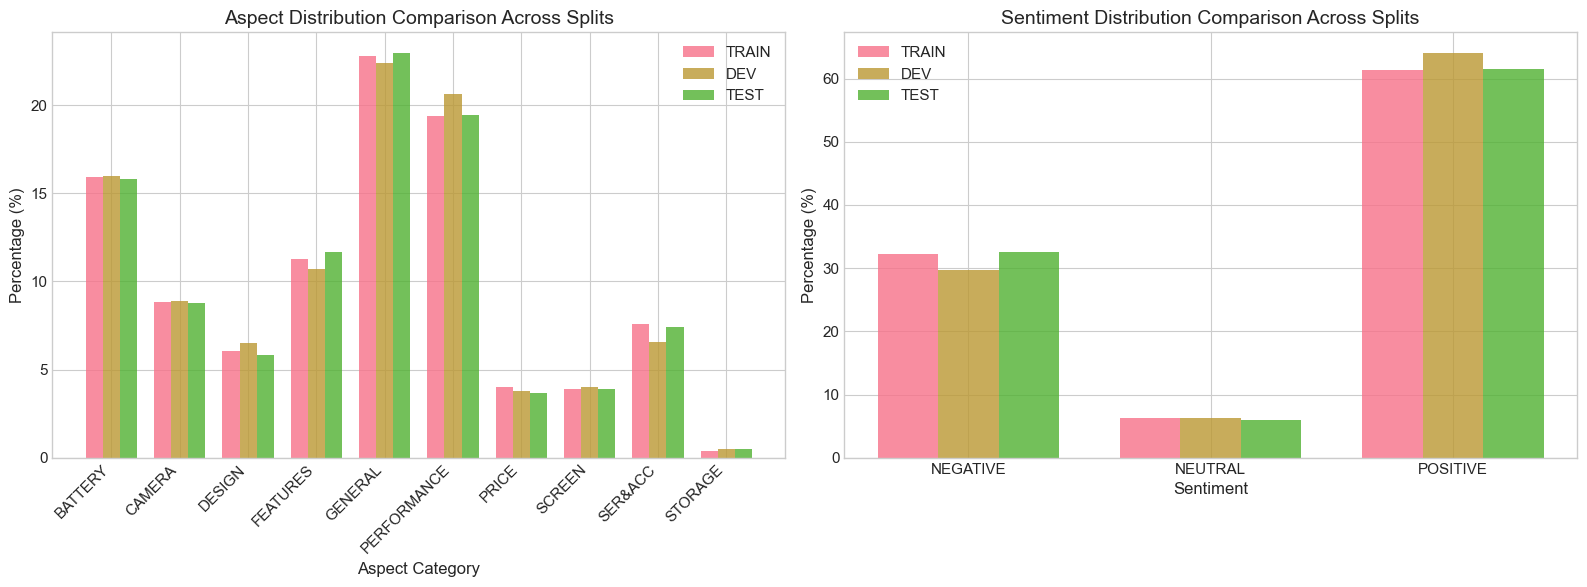


------------------------------------------------------------
OBSERVATION:
------------------------------------------------------------
- Aspect and sentiment distributions are consistent across train/dev/test splits
- This indicates proper stratified splitting was applied during dataset creation
- Models trained on this data should generalize well across splits


In [ ]:
# Visualization of split comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Aspect distribution comparison
split_order = ['train', 'dev', 'test']
x = np.arange(len(aspect_by_split_pct.columns))
width = 0.25

for i, split in enumerate(split_order):
    if split in aspect_by_split_pct.index:
        axes[0].bar(x + i * width, aspect_by_split_pct.loc[split].values, 
                    width, label=split.upper(), alpha=0.8)

axes[0].set_xlabel('Aspect Category')
axes[0].set_ylabel('Percentage (%)')
axes[0].set_title('Aspect Distribution Comparison Across Splits')
axes[0].set_xticks(x + width)
axes[0].set_xticklabels(aspect_by_split_pct.columns, rotation=45, ha='right')
axes[0].legend()

# Sentiment distribution comparison
x = np.arange(len(sentiment_by_split_pct.columns))
for i, split in enumerate(split_order):
    if split in sentiment_by_split_pct.index:
        axes[1].bar(x + i * width, sentiment_by_split_pct.loc[split].values, 
                    width, label=split.upper(), alpha=0.8)

axes[1].set_xlabel('Sentiment')
axes[1].set_ylabel('Percentage (%)')
axes[1].set_title('Sentiment Distribution Comparison Across Splits')
axes[1].set_xticks(x + width)
axes[1].set_xticklabels(sentiment_by_split_pct.columns)
axes[1].legend()

plt.tight_layout()
plt.savefig('statistical_result/split_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

# Observation
print("\n" + "-" * 60)
print("OBSERVATION:")
print("-" * 60)
print("- Aspect and sentiment distributions are consistent across train/dev/test splits")
print("- This indicates proper stratified splitting was applied during dataset creation")
print("- Models trained on this data should generalize well across splits")


## 8. Summary and Key Findings

Comprehensive summary of the UIT-ViSD4SA dataset statistical analysis.


In [19]:
# Comprehensive Summary
print("=" * 80)
print("UIT-ViSD4SA DATASET STATISTICAL SUMMARY")
print("=" * 80)

print("\n1. DATASET OVERVIEW")
print("-" * 40)
print(f"   Total samples: {len(df):,}")
print(f"   Train/Dev/Test split: {len(datasets['train']):,} / {len(datasets['dev']):,} / {len(datasets['test']):,}")
print(f"   Split ratio: {len(datasets['train'])/len(df)*100:.1f}% / {len(datasets['dev'])/len(df)*100:.1f}% / {len(datasets['test'])/len(df)*100:.1f}%")

print("\n2. ANNOTATION STATISTICS")
print("-" * 40)
print(f"   Total annotations: {len(labels_df):,}")
print(f"   Average annotations/sample: {df['num_labels'].mean():.2f}")
print(f"   Samples with no annotations: {empty_count:,} ({empty_pct:.2f}%)")
print(f"   Multi-label samples: {multi_label_count:,} ({multi_label_pct:.2f}%)")

print("\n3. ASPECT CATEGORIES (Top 5)")
print("-" * 40)
for aspect, count in aspect_counts.head(5).items():
    pct = count / len(labels_df) * 100
    print(f"   {aspect}: {count:,} ({pct:.1f}%)")

print("\n4. SENTIMENT DISTRIBUTION")
print("-" * 40)
for sentiment, count in sentiment_counts.items():
    pct = count / len(labels_df) * 100
    print(f"   {sentiment}: {count:,} ({pct:.1f}%)")

print("\n5. TEXT LENGTH")
print("-" * 40)
print(f"   Average word count: {df['word_count'].mean():.1f} (std: {df['word_count'].std():.1f})")
print(f"   Average char count: {df['char_count'].mean():.1f} (std: {df['char_count'].std():.1f})")

print("\n6. KEY FINDINGS")
print("-" * 40)
print("   - The dataset exhibits class imbalance with POSITIVE sentiment dominating")
print("   - Most reviews contain 1-3 aspect-sentiment annotations")
print("   - GENERAL and PERFORMANCE are the most frequently annotated aspects")
print("   - Data splits are well-balanced for reproducible experiments")
print("   - Vietnamese e-commerce reviews are typically short (< 50 words)")

print("\n" + "=" * 80)


UIT-ViSD4SA DATASET STATISTICAL SUMMARY

1. DATASET OVERVIEW
----------------------------------------
   Total samples: 11,122
   Train/Dev/Test split: 7,785 / 1,112 / 2,225
   Split ratio: 70.0% / 10.0% / 20.0%

2. ANNOTATION STATISTICS
----------------------------------------
   Total annotations: 35,396
   Average annotations/sample: 3.18
   Samples with no annotations: 225 (2.02%)
   Multi-label samples: 9,168 (82.43%)

3. ASPECT CATEGORIES (Top 5)
----------------------------------------
   GENERAL: 8,057 (22.8%)
   PERFORMANCE: 6,906 (19.5%)
   BATTERY: 5,630 (15.9%)
   FEATURES: 3,994 (11.3%)
   CAMERA: 3,117 (8.8%)

4. SENTIMENT DISTRIBUTION
----------------------------------------
   POSITIVE: 21,832 (61.7%)
   NEGATIVE: 11,350 (32.1%)
   NEUTRAL: 2,214 (6.3%)

5. TEXT LENGTH
----------------------------------------
   Average word count: 36.0 (std: 20.1)
   Average char count: 158.3 (std: 87.8)

6. KEY FINDINGS
----------------------------------------
   - The dataset exhibit

In [ ]:
# Export summary statistics to CSV
summary_export = pd.DataFrame({
    'Metric': [
        'Total Samples', 'Train Samples', 'Dev Samples', 'Test Samples',
        'Total Annotations', 'Avg Annotations/Sample',
        'Samples with No Annotations', 'Multi-label Samples',
        'Avg Word Count', 'Avg Char Count',
        'Positive Sentiment %', 'Negative Sentiment %', 'Neutral Sentiment %'
    ],
    'Value': [
        len(df), len(datasets['train']), len(datasets['dev']), len(datasets['test']),
        len(labels_df), f"{df['num_labels'].mean():.2f}",
        empty_count, multi_label_count,
        f"{df['word_count'].mean():.1f}", f"{df['char_count'].mean():.1f}",
        f"{sentiment_pct.get('POSITIVE', 0):.2f}%",
        f"{sentiment_pct.get('NEGATIVE', 0):.2f}%",
        f"{sentiment_pct.get('NEUTRAL', 0):.2f}%"
    ]
})

summary_export.to_csv('statistical_result/dataset_summary.csv', index=False)
print("Summary statistics exported to 'dataset_summary.csv'")

# Display sample data
print("\n" + "=" * 80)
print("SAMPLE DATA EXAMPLES")
print("=" * 80)
samples = df.sample(3, random_state=42)
for idx, row in samples.iterrows():
    print(f"\nText: {row['text'][:150]}...")
    print(f"Labels: {len(row['labels'])} annotation(s)")
    for label in row['parsed_labels'][:3]:
        print(f"  - [{label['aspect']}#{label['sentiment']}] span: {label['span_length']} chars")


Summary statistics exported to 'dataset_summary.csv'

SAMPLE DATA EXAMPLES

Text: Mới dùng 2 tháng nhưng nay thỉnh thoảng mất kết nối sim phải chọc sim ra r lắp lại mới bình thường @@...
Labels: 1 annotation(s)
  - [FEATURES#NEGATIVE] span: 42 chars

Text: Toàn bị lỗi camera khó chịu,mở lên lúc được lúc không lâu lâu bị đơ nữa haizzzzzzz...
Labels: 1 annotation(s)
  - [CAMERA#NEGATIVE] span: 77 chars

Text: Không cho kết nối cáp usb với máy tính. Không hỗ trợ ucb otg. Quá tệ cho mức giá tầm trung. Thua cả những máy đời cũ. Được mỗi bộ nhớ trong 128 gb...
Labels: 3 annotation(s)
  - [FEATURES#NEGATIVE] span: 60 chars
  - [GENERAL#NEGATIVE] span: 54 chars
  - [STORAGE#POSITIVE] span: 28 chars
